Libraries Used

In [7]:
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

import numpy as np
import scipy
import scipy.signal
import pandas as pd
import datetime
import os

import matplotlib.dates as mdates

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.cm as cm
import cartopy.feature as cfeature

from datetime import timedelta

import imageio

from matplotlib import gridspec
from matplotlib.ticker import MaxNLocator

#### Helper Functions:
Load all

In [2]:
data_folder = '/Users/dlugardo/Desktop/data/ENU_v2' # path to the folder with the data 

def get_data(location):
    file_name = str(location) + '.ENU.txt'
    path = os.path.join(data_folder, file_name)

    if os.path.isfile(path):
        data = np.loadtxt(path, skiprows=2)
    else:
        file_name = str(location) + '_ENU.txt'
        path = os.path.join(data_folder, file_name)

        if os.path.isfile(path):
            data = np.loadtxt(path, skiprows=2)
        else:
            raise FileNotFoundError(f"Neither '{location}.ENU.txt' nor '{location}_ENU.txt' found in {data_folder}")
    return data

def decimal_year_to_date(decimal_year):
    """
    Converts a decimal year to a datetime.date object.
    """
    year = int(decimal_year)
    fractional_part = decimal_year - year

    # Determine if it's a leap year for accurate day calculation
    is_leap = (year % 4 == 0 and year % 100 != 0) or (year % 400 == 0)
    days_in_year = 366 if is_leap else 365

    # Calculate the number of days from the start of the year
    days_offset = fractional_part * days_in_year

    # Create a datetime object for January 1st of that year
    start_of_year = datetime.date(year, 1, 1)

    # Add the calculated offset in days
    result_date = start_of_year + datetime.timedelta(days=days_offset)

    return result_date

def doy_to_angle(doy):
    radians = doy * 2 * np.pi / 365
    mean_angle = np.arctan2(np.mean(np.sin(radians)), np.mean(np.cos(radians)))
    cos = np.cos(mean_angle)
    return(cos)

def circular_mean(doys):
    radians = doys * 2 * np.pi / 365
    mean_angle = np.arctan2(np.mean(np.sin(radians)), np.mean(np.cos(radians)))
    mean_doy = (mean_angle * 365 / (2 * np.pi)) % 365
    return round(mean_doy)

MAX_GAP_DAYS = 14 

def find_longest_continuous_segment(dates, max_gap_days=14):
    # Ensure dates are sorted
    dates = np.sort(dates)
    segments = []
    current_segment = [dates[0]]

    for i in range(1, len(dates)):
        if (dates[i] - dates[i-1]).days <= max_gap_days:
            current_segment.append(dates[i])
        else:
            segments.append(current_segment)
            current_segment = [dates[i]]
    segments.append(current_segment)

    # Return the longest continuous segment
    return max(segments, key=len)

In [205]:
def InterpRA(data, detrend, INTERP_LIMIT, wdays):
    time = data[:, 0]

    if detrend == True:   
        data[:, 1:4] = scipy.signal.detrend(data[:, 1:4], axis=0)
        
    converted_dates = np.array([decimal_year_to_date(dy) for dy in time])
    df = pd.DataFrame({'Date': converted_dates})
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)

    df['East'] = data[:, 1]
    df['North'] = data[:, 2]
    df['Vertical'] = data[:, 3]

    df['year'] = df.index.year
    df['doy'] = df.index.dayofyear

    filled_list = []
    for year, group in df.groupby('year'):
        # Determine if leap year
        is_leap = (pd.Timestamp(f'{year}-12-31').is_leap_year)
        days_in_year = 366 if is_leap else 365

        # Create full day-of-year range
        full_range = pd.DataFrame({'doy': np.arange(1, days_in_year + 1)})
        full_range['year'] = year

        # Merge to include missing days as NaN
        group = full_range.merge(group, on=['year', 'doy'], how='left')

        # Remove duplicates by averaging
        group = group.groupby(['year', 'doy'], as_index=False).mean()

        # Restore datetime index
        group['Date'] = pd.to_datetime(
            group['year'].astype(str) + '-' + group['doy'].astype(str),
            format='%Y-%j',
            errors='coerce'
        )
        group = group.set_index('Date').sort_index()

    df = pd.concat(filled_list).sort_index()
    
    df_rolling = df.rolling(window=wdays, center=True, min_periods=wdays-int(wdays/5)).mean()
    df_rolling = df_rolling.dropna()
    
    df_rolling['month_day'] = df_rolling.index.strftime('%m-%d')
    df_rolling = df_rolling[df_rolling.index.strftime('%m-%d') != '02-29']

    # reattach integer year and doy
    df_rolling['year'] = df_rolling.index.year
    df_rolling['doy'] = df_rolling.index.dayofyear
    df_rolling['month_day'] = df_rolling.index.strftime('%m-%d')

    return df_rolling

In [206]:
def InterpRA(data, detrend, INTERP_LIMIT, wdays):   
    time = data[:, 0]

    if detrend:   
        data[:, 1:4] = scipy.signal.detrend(data[:, 1:4], axis=0)
        
    # Convert decimal year to datetime
    converted_dates = np.array([decimal_year_to_date(dy) for dy in time])
    df = pd.DataFrame({'Date': pd.to_datetime(converted_dates)})
    df.set_index('Date', inplace=True)

    df['East'] = data[:, 1]
    df['North'] = data[:, 2]
    df['Vertical'] = data[:, 3]

    df['year'] = df.index.year
    df['doy'] = df.index.dayofyear

    filled_list = []
    for year, group in df.groupby('year'):
        # Determine if leap year
        is_leap = (pd.Timestamp(f'{year}-12-31').is_leap_year)
        days_in_year = 366 if is_leap else 365

        # Create full day-of-year range
        full_range = pd.DataFrame({'doy': np.arange(1, days_in_year + 1)})
        full_range['year'] = year

        # Merge to include missing days as NaN
        group = full_range.merge(group, on=['year', 'doy'], how='left')

        # Remove duplicates by averaging
        group = group.groupby(['year', 'doy'], as_index=False).mean()

        # Restore datetime index
        group['Date'] = pd.to_datetime(
            group['year'].astype(str) + '-' + group['doy'].astype(str),
            format='%Y-%j',
            errors='coerce'
        )
        group = group.set_index('Date').sort_index()


    # Concatenate all years
    df = pd.concat(filled_list).sort_index()
    
    # Apply rolling mean smoothing
    df_rolling = df.rolling(window=wdays, center=True, min_periods=wdays - int(wdays / 5)).mean()
    df_rolling = df_rolling.dropna()

    # Remove Feb 29 for consistency
    df_rolling = df_rolling[df_rolling.index.strftime('%m-%d') != '02-29']
    
    # Reattach year, day of year, and month_day columns
    df_rolling['year'] = df_rolling.index.year
    df_rolling['doy'] = df_rolling.index.dayofyear
    df_rolling['month_day'] = df_rolling.index.strftime('%m-%d')

    return df_rolling

In [117]:
# Loads the Metadata for all the station (latitude, longitude, and elevation)
StationMetaData = df = pd.read_csv('/Users/dlugardo/Documents/GitHub/signal-processing-enu/GreenlandStations.csv')
StationMetaData

,station,latitude,longitude,elevation_m,is_greenland
0,NGFJ,80.568475,-16.841131,35.5,True
1,JWLF,83.111656,-45.119847,112.9,True
2,THU4,76.537106,-68.824953,36.2,True
3,JGBL,82.208758,-31.004208,753.3,True
4,THU2,76.537047,-68.825050,36.2,True
...,...,...,...,...,...
71,MIK2,68.140281,-31.451825,815.9,True
72,KUAQ,68.587000,-33.052750,865.2,True
73,KSUT,64.070697,-52.007697,40.7,True
74,RINK,71.848500,-50.993967,1337.9,True


### Specific Tasks
## Long Term Mean CSV creation

In [202]:
stations_names_with_data, metadata_records = [], []

MAX_GAP_DAYS = 14 
INTERP_LIMIT = 8  
wdays = 30
min_years_per_doy = 2
MIN_DAYS_PER_YEAR = 350

for station_name in StationMetaData.station:
    try:
        raw_data = get_data(station_name)
        time = raw_data[:, 0]
        converted_dates = np.array([decimal_year_to_date(dy) for dy in time])

        # Find longest continuous segment of data
        continuous_segment = find_longest_continuous_segment(
            converted_dates, max_gap_days=MAX_GAP_DAYS
        )

        if len(continuous_segment) < 365 * 3:  # optional: skip if segment is too short
            print(f"  → Skipping {station_name}: continuous segment too short.")
            continue

        # Filter both data and error to this segment
        mask = np.isin(converted_dates, continuous_segment)
        data = raw_data[mask, :]

        df_rolling = InterpRA(data, True, INTERP_LIMIT, wdays)

        valid_years = df_rolling.groupby('year').filter(
            lambda x: len(x) >= MIN_DAYS_PER_YEAR
        )['year'].unique()
        df_rolling = df_rolling[df_rolling['year'].isin(valid_years)]
        
        LTM = df_rolling.groupby('month_day')[['East', 'North', 'Vertical']].mean()
        stds = df_rolling.groupby('month_day')[['East', 'North', 'Vertical']].std()
        
        stds.columns = ['East_sd', 'North_sd', 'Vertical_sd']
        LTM = LTM.join(stds)
        
        counts = df_rolling.groupby('month_day').size()
        good_days = counts[counts >= min_years_per_doy].index
        LTM = LTM.loc[good_days]

        LTM[['East','North','Vertical']] = (
            LTM[['East','North','Vertical']].rolling(4, center=True, min_periods=1).mean()
        )

        # Save LTM for this station
        LTM.to_csv(
            f'/Users/dlugardo/Documents/GitHub/signal-processing-enu/LTM/files/{station_name}_Daily{wdays}RollingLTM.csv',
            index=True)

        stations_names_with_data.append(station_name)

    except FileNotFoundError:
        print(f"  → File not found for station {station_name}. Skipping.")
        continue
    except Exception as e:
        print(f"  → Error processing station {station_name}: {e}")
        continue

  → Skipping NGFJ: continuous segment too short.
  → File not found for station THU4. Skipping.
  → File not found for station QENU. Skipping.
  → File not found for station AAS2. Skipping.
  → Skipping EQNU: continuous segment too short.
  → Skipping SCOB: continuous segment too short.
  → File not found for station SCO4. Skipping.
  → File not found for station STNO. Skipping.
  → File not found for station QAQ2. Skipping.
  → File not found for station KLQ3. Skipping.
  → Skipping UPAK: continuous segment too short.
  → Skipping AVAN: continuous segment too short.
  → Skipping THU1: continuous segment too short.
  → File not found for station THU3. Skipping.
  → Skipping NUNA: continuous segment too short.
  → File not found for station KSUT. Skipping.


## Plotting of the Data
Note that the StDev is quite big as there is a lot of fluctuation in the mean of every year (Multidecadal systems)

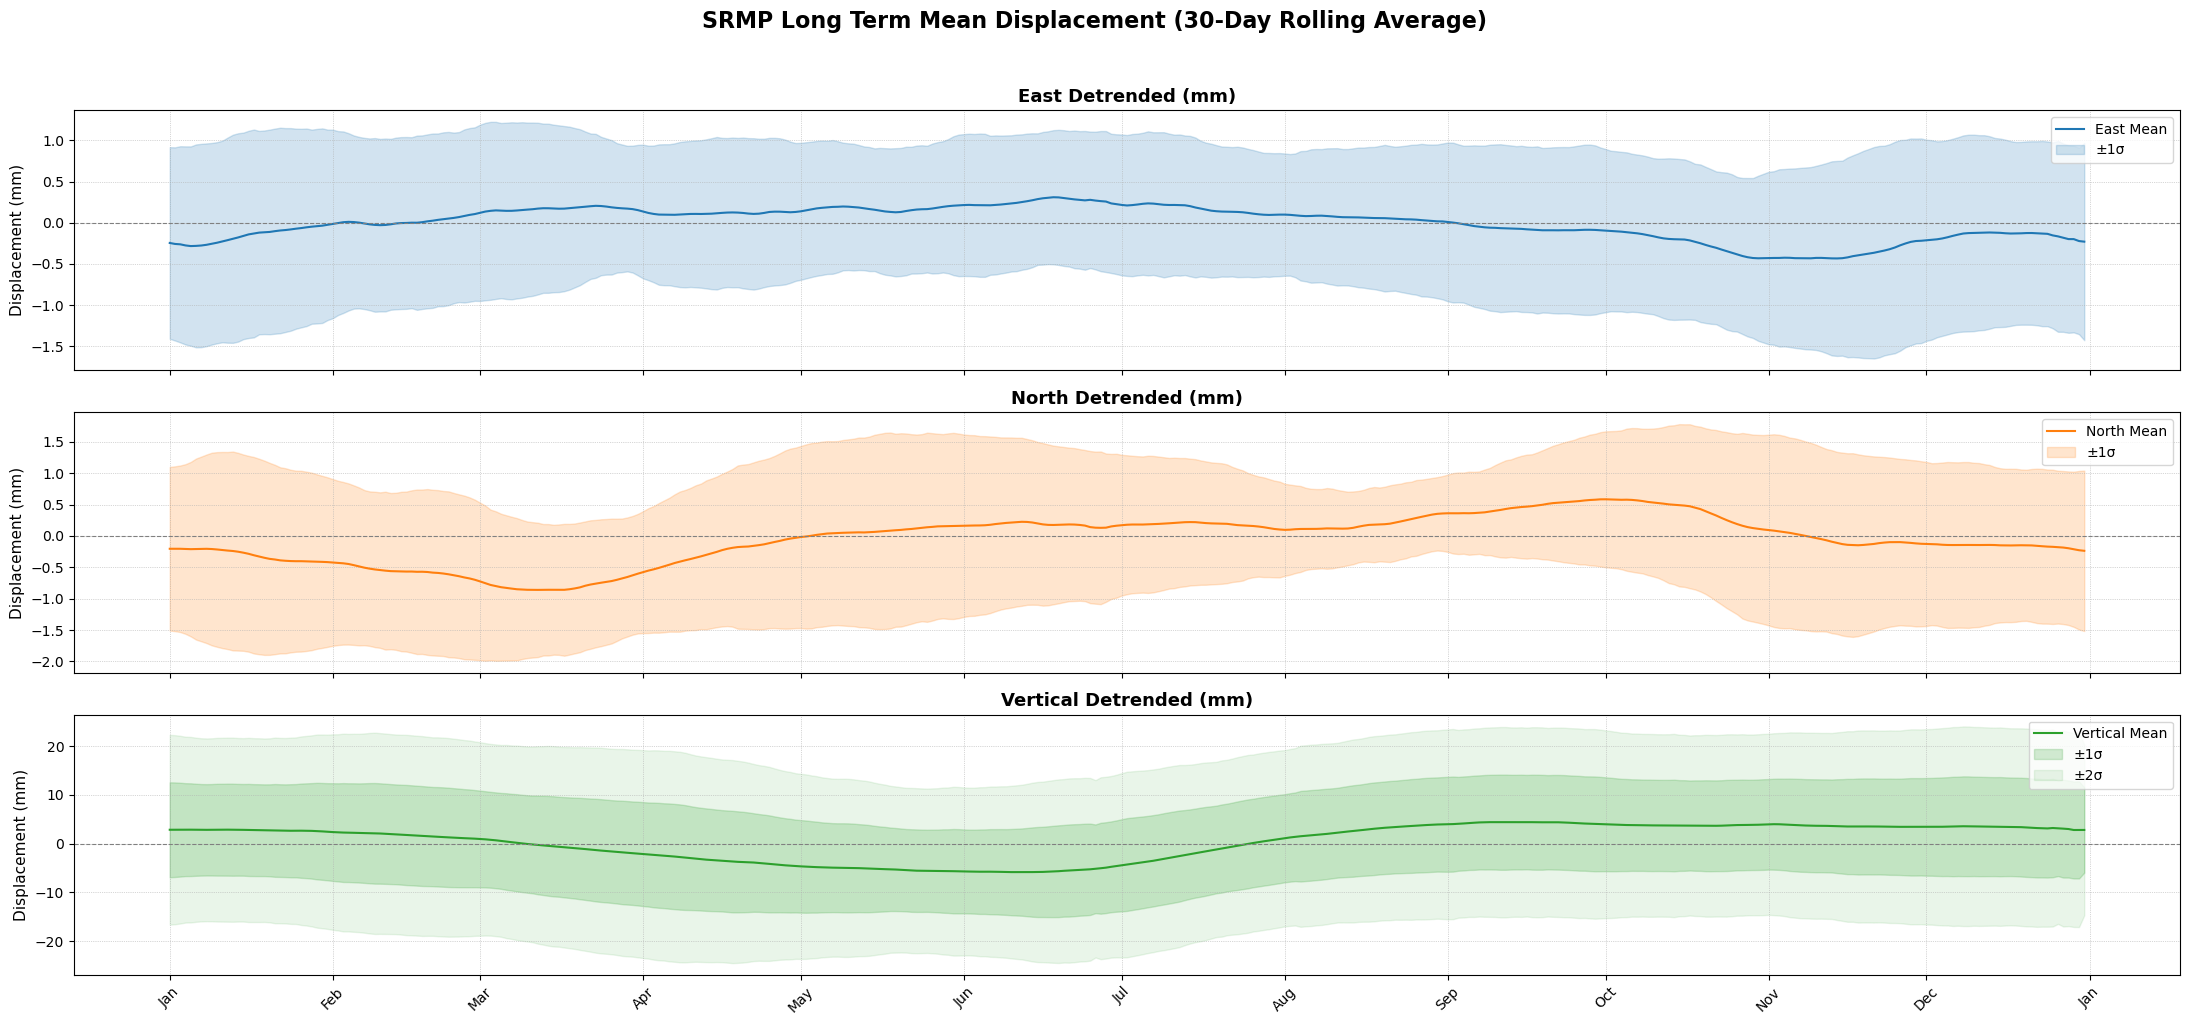

In [156]:
# Load data
station = 'SRMP'
climatology_daily = pd.read_csv('/Users/dlugardo/Documents/GitHub/signal-processing-enu/LTM/files/' + station + '_Daily30RollingLTM.csv') # ',{station_name}_Daily{wdays}RollingLTM.csv

# Set up the figure and subplots
fig, axs = plt.subplots(3, 1, figsize=(22, 10), sharex=True)

# Define colors
colors = {'East': '#1f77b4', 'North': '#ff7f0e', 'Vertical': '#2ca02c'}

# Plot each component
components = ['East', 'North', 'Vertical']
titles = ['East Detrended (mm)', 'North Detrended (mm)', 'Vertical Detrended (mm)']

for i, component in enumerate(components):
    ax = axs[i]
    sd = climatology_daily[component + '_sd']
    ax.plot(climatology_daily['month_day'], climatology_daily[component], label=f'{component.title()} Mean', color=colors[component])
    ax.axhline(0, color='gray', linewidth=0.8, linestyle='--')

    # 1-sigma shading
    ax.fill_between(climatology_daily['month_day'],
                    climatology_daily[component] - sd,
                    climatology_daily[component] + sd,
                    color=colors[component], alpha=0.2, label='±1σ')

    # 2-sigma only for 'up'
    if component == 'Vertical':
        ax.fill_between(climatology_daily['month_day'],
                        climatology_daily[component] - 2 * sd,
                        climatology_daily[component] + 2 * sd,
                        color=colors[component], alpha=0.1, label='±2σ')

    ax.set_title(titles[i], fontsize=13, weight='bold')
    ax.grid(True, linestyle=':', linewidth=0.5)
    ax.legend(loc='upper right', fontsize=10)
    ax.set_ylabel('Displacement (mm)', fontsize=11)

# X-axis settings
#axs[-1].set_xlabel('Date (MM-DD)', fontsize=12)
axs[-1].xaxis.set_major_locator(mdates.MonthLocator())
axs[-1].xaxis.set_major_formatter(mdates.DateFormatter('%b'))

# Rotate x labels
plt.setp(axs[-1].xaxis.get_majorticklabels(), rotation=45)

# Add overall title
fig.suptitle(f'{station} Long Term Mean Displacement (30-Day Rolling Average)', fontsize=16, weight='bold', y=1.02)

# Final layout tweaks
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()


## Animation of Vectors

In [ ]:
Time_days =  pd.read_csv('/Users/dlugardo/Documents/GitHub/signal-processing-enu/LTM/files/SRMP_DailyLTM.csv').month_day

cmap = cm.coolwarm_r
vmin = -7  # or use np.nanmin of all station 'up' values if precomputed
vmax = 7   # same as above
norm = colors.Normalize(vmin=vmin, vmax=vmax)

filenames = []  

for n, month_day in enumerate(Time_days):
    fig= plt.figure(figsize=(8,11))
    ax = plt.axes(projection=ccrs.Stereographic())
    plt.title("Deterended LTM Daily Average (30 Days Rolled Average) Displacement " + str(month_day))

    ax.set_extent([-55, -5, 55, 90])
    ax.gridlines(draw_labels=True)
    ax.stock_img()
    ax.coastlines(resolution='10m', alpha = 0.3)

    for station in stations_names_with_data:
        climatology_daily = pd.read_csv('/Users/dlugardo/Documents/GitHub/signal-processing-enu/LTM/files/' + station + '_Daily30RollingLTM.csv')
        smdt = StationMetaData.loc[StationMetaData['station'] == station]

        lon = smdt.longitude
        lat = smdt.latitude

        ax.plot(lon, lat, marker='o', color='black', markersize=2, alpha=0.6, transform=ccrs.Geodetic())
        
        U = np.array([climatology_daily['East'].iloc[n]])
        V = np.array([climatology_daily['North'].iloc[n]])
        C = np.array(climatology_daily['Up'].iloc[n]) 

        scale_factor = 12

        ax.quiver(
            lon, lat, U , V ,
            [C],  # color mapped by vertical component
            scale=scale_factor,
            transform=ccrs.PlateCarree(),
            cmap=cmap,
            norm=norm,
            width=0.005,
            alpha=1,
            edgecolor='k',
            linewidth=0.5,
            headwidth=2,         # smaller width
            headlength=2,        # smaller length
            headaxislength=2.5
        )
        magnitude = np.sqrt(U**2 + V**2)
        #print(f"{station} @ {month}: U={U}, V={V}, Mag={magnitude}")


    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  # only needed for colorbar
    cbar = plt.colorbar(sm, ax=ax, orientation='vertical', shrink=0.6, pad=0.02)
    cbar.set_label('Vertical Displacement (mm)')


    ref_mm = 1  # reference displacement in mm
    ref_units = ref_mm  # length in plot units

    Q = ax.quiver(
        np.array([0]), np.array([0]),
        np.array([1]), np.array([0]),
        transform=ccrs.PlateCarree(),
        scale=scale_factor,
    )

    ax.quiverkey(
        Q,
        X=0.55, Y=-0.1, U=ref_units,
        label=f'{ref_mm} mm',
        labelpos='E',
        coordinates='axes'
    )

    plt.tight_layout()
    filename = f'/Users/dlugardo/Documents/GitHub/signal-processing-enu/Visualization/PlotsforAnimations/LTM_MapVis_{month_day}_30Rolling.png'
    plt.savefig(filename)
    filenames.append(filename)
    plt.close()
    
with imageio.get_writer('/Users/dlugardo/Documents/GitHub/signal-processing-enu/Visualization/LTM_MapVis_Daily30Rolling.gif', mode='I', duration=20) as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

with imageio.get_writer('/Users/dlugardo/Documents/GitHub/signal-processing-enu/Visualization/LTM_MapVis_Daily30Rolling.mp4' , fps=12) as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
        

## Overplotting Every Year for a Station

In [207]:
Disp = 'Vertical'
station_name = 'SRMP'
raw_data = get_data(station_name)
INTERP_LIMIT = 3  
wdays = 30
rd_data = InterpRA(raw_data, True, INTERP_LIMIT, wdays )

years = sorted(np.unique(rd_data.year))

ValueError: No objects to concatenate

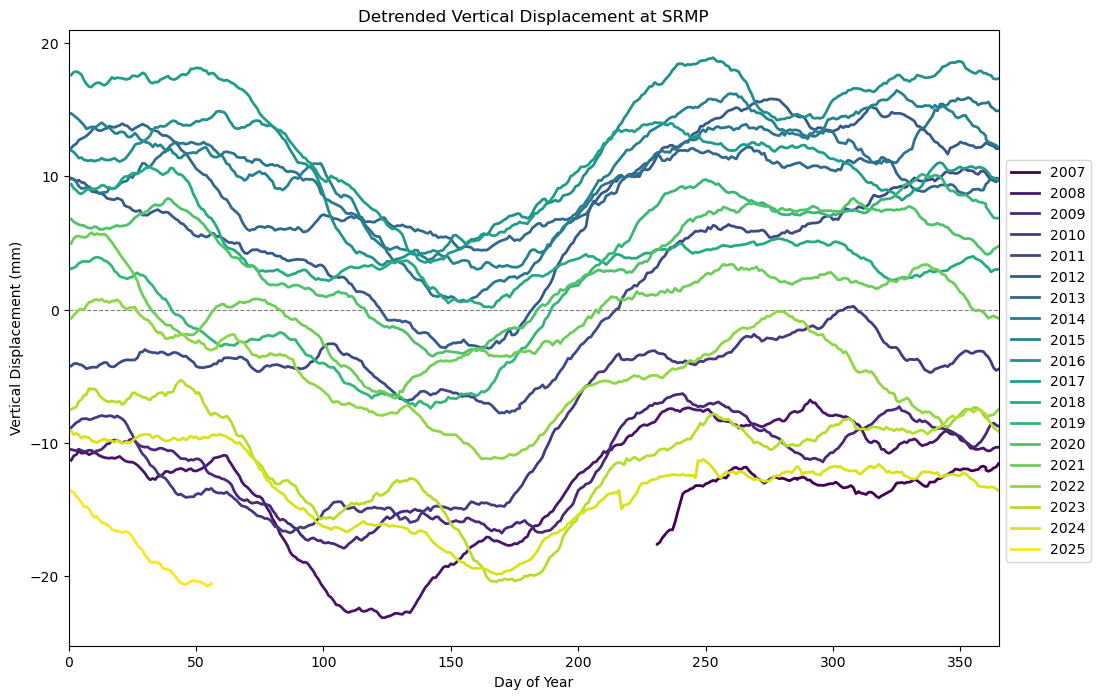

In [163]:
fig= plt.figure(figsize=(12,8))

col  = cm.get_cmap('viridis', len(years))

peak, minima, amplitude, years_used, filenames = [],[], [], [], []
plt.xlabel('Day of Year')
plt.ylabel( Disp + ' Displacement (mm)')
plt.title('Detrended ' + Disp + ' Displacement at ' + station_name)
plt.axhline(0, color='gray', linewidth=0.8, linestyle='--')
plt.xlim(0, 365)


for i, year in enumerate(years):
    data = rd_data[rd_data['year'] == year]

    if data.shape[0] > 350:
        years_used.append(str(year))
        a = data[Disp].idxmin()
        minima.append(data['doy'][a])

        b = data[Disp].idxmax()
        peak.append(data['doy'][b])

        a1 = data[Disp].min()
        b1 = data[Disp].max()
        amplitude.append(b1-a1)

    plt.plot(data['doy'], data[Disp], label = year, color = col(i), lw = 2)
    plt.legend(bbox_to_anchor=(1, 0.8))
    filename = ('/Users/dlugardo/Documents/GitHub/signal-processing-enu/Visualization/PlotsforAnimations/Det'+ Disp + 'Disp_' + station_name + '_' + str(year) + '.png')
    plt.savefig(filename)
    filenames.append(filename)
    
with imageio.get_writer('/Users/dlugardo/Documents/GitHub/signal-processing-enu/Visualization/Det'+Disp+'Disp_' + station_name + '.gif', mode='I', duration=150.0) as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

peak = np.array(peak)
minima = np.array(minima)
amplitude = np.array(amplitude)
years_used = np.array(years_used)

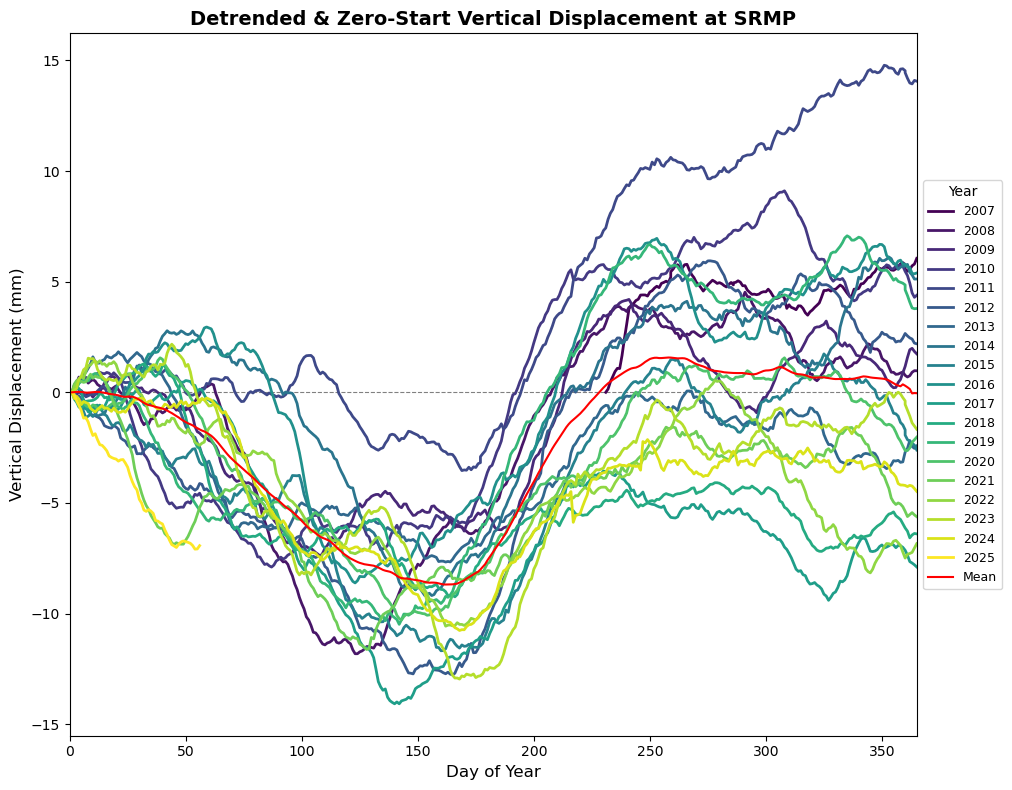

In [164]:
fig = plt.figure(figsize=(12, 8))
filenames = []

years = sorted(np.unique(rd_data.year))
colormap = cm.get_cmap('viridis', len(years))

plt.xlabel('Day of Year', fontsize=12)
plt.ylabel(Disp + ' Displacement (mm)', fontsize=12)
plt.title(f'Detrended & Zero-Start {Disp} Displacement at {station_name}', fontsize=14, weight='bold')
plt.axhline(0, color='gray', linewidth=0.8, linestyle='--')
plt.xlim(0, 365)

for i, year in enumerate(years):
    data = rd_data[rd_data['year'] == year]

    offset_up = data[Disp] - data[Disp].iloc[0]
    plt.plot(data['doy'], offset_up, label=str(year), color=colormap(i), lw=2)
    
    plt.legend(title="Year", loc='center left', bbox_to_anchor=(1, 0.5), fontsize=9)

    filename = f'/Users/dlugardo/Documents/GitHub/signal-processing-enu/Visualization/PlotsforAnimations/Det0{Disp}Disp_{station_name}_{year}.png'
    plt.tight_layout(rect=[0, 0, 0.85, 1])
    plt.savefig(filename, dpi=150)
    filenames.append(filename)

data = rd_data[rd_data['year'] == 2022]
LTM = pd.read_csv('/Users/dlugardo/Documents/GitHub/signal-processing-enu/LTM/files/SRMP_Daily30RollingLTM.csv')
offset_up_LTM = LTM[Disp] - LTM[Disp].iloc[0]
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.plot(data['doy'], offset_up_LTM, label = 'Mean', c= 'red')
plt.legend(title="Year", loc='center left', bbox_to_anchor=(1, 0.5), fontsize=9)

filename = f'/Users/dlugardo/Documents/GitHub/signal-processing-enu/Visualization/PlotsforAnimations/Det0{Disp}Disp_{station_name}_Mean.png'
plt.savefig(filename, dpi=150)
filenames.append(filename)

gif_path = f'/Users/dlugardo/Documents/GitHub/signal-processing-enu/Visualization/Det0{Disp}Disp_{station_name}.gif'
with imageio.get_writer(gif_path, mode='I', duration=200) as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

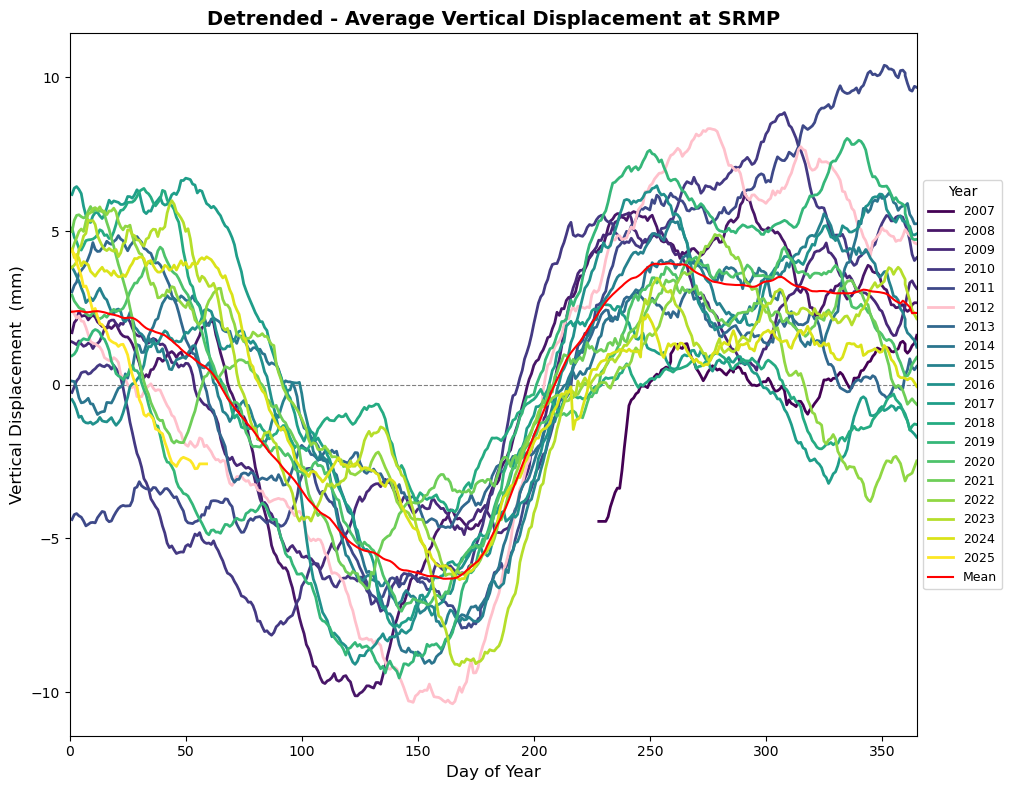

In [165]:
fig = plt.figure(figsize=(12, 8))
filenames = []

years = sorted(np.unique(rd_data.year))
colormap = cm.get_cmap('viridis', len(years))

plt.xlabel('Day of Year', fontsize=12)
plt.ylabel(Disp + ' Displacement  (mm)', fontsize=12)
plt.title(f'Detrended - Average Vertical Displacement at {station_name}', fontsize=14, weight='bold')
plt.axhline(0, color='gray', linewidth=0.8, linestyle='--')
plt.xlim(0, 365)

for i, year in enumerate(years):
    data = rd_data[rd_data['year'] == year]
    full_range = pd.DataFrame({'doy': np.arange(1, 366)})
    data = full_range.merge(data, on="doy", how="left")
    data['year'] = str(year)
    data[Disp] = data[Disp].interpolate(method="linear", limit=3, limit_direction="both")

    avg = np.nanmean(data[Disp])
    offset = data[Disp] - avg

    if year == 2012:
        co = 'pink'
    else:
        co = colormap(i)
    plt.plot(data['doy'], offset, label=str(year), color=co, lw=2)
    
    plt.legend(title="Year", loc='center left', bbox_to_anchor=(1, 0.5), fontsize=9)

    filename = f'/Users/dlugardo/Documents/GitHub/signal-processing-enu/Visualization/PlotsforAnimations/Det0{Disp}Disp_{station_name}_{year}.png'
    plt.tight_layout(rect=[0, 0, 0.85, 1])
    plt.savefig(filename, dpi=150)
    filenames.append(filename)

data = rd_data[rd_data['year'] == 2013]
LTM = pd.read_csv('/Users/dlugardo/Documents/GitHub/signal-processing-enu/LTM/files/SRMP_Daily30RollingLTM.csv')
offset_LTM = LTM[Disp] - np.mean(LTM[Disp])
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.plot(data['doy'], offset_LTM, label = 'Mean', c= 'red')
plt.legend(title="Year", loc='center left', bbox_to_anchor=(1, 0.5), fontsize=9)

filename = f'/Users/dlugardo/Documents/GitHub/signal-processing-enu/Visualization/PlotsforAnimations/Compressed{Disp}Disp_{station_name}_Mean.png'
plt.savefig(filename, dpi=150)
filenames.append(filename)

gif_path = f'/Users/dlugardo/Documents/GitHub/signal-processing-enu/Visualization/Compressed{Disp}Disp_{station_name}.gif'
with imageio.get_writer(gif_path, mode='I', duration=200) as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

In [209]:
rd_data[rd_data['year'] == 2008]

,year,doy,East,North,Vertical,month_day
Date,,,,,,
2008-01-01,2008,1,0.141999,1.370345,-11.508454,01-01
2008-01-02,2008,2,0.043674,1.338270,-11.206388,01-02
2008-01-03,2008,3,-0.037118,1.336795,-10.922155,01-03
2008-01-04,2008,4,-0.107776,1.360353,-10.741888,01-04
2008-01-05,2008,5,-0.183568,1.418212,-10.757389,01-05
...,...,...,...,...,...,...
2008-12-26,2008,361,1.490677,1.220280,-10.609889,12-26
2008-12-27,2008,362,1.425784,1.286909,-10.551783,12-27
2008-12-28,2008,363,1.358425,1.311372,-10.396310,12-28


ValueError: 'x' has size 365, but 'y1' has an unequal size of 366

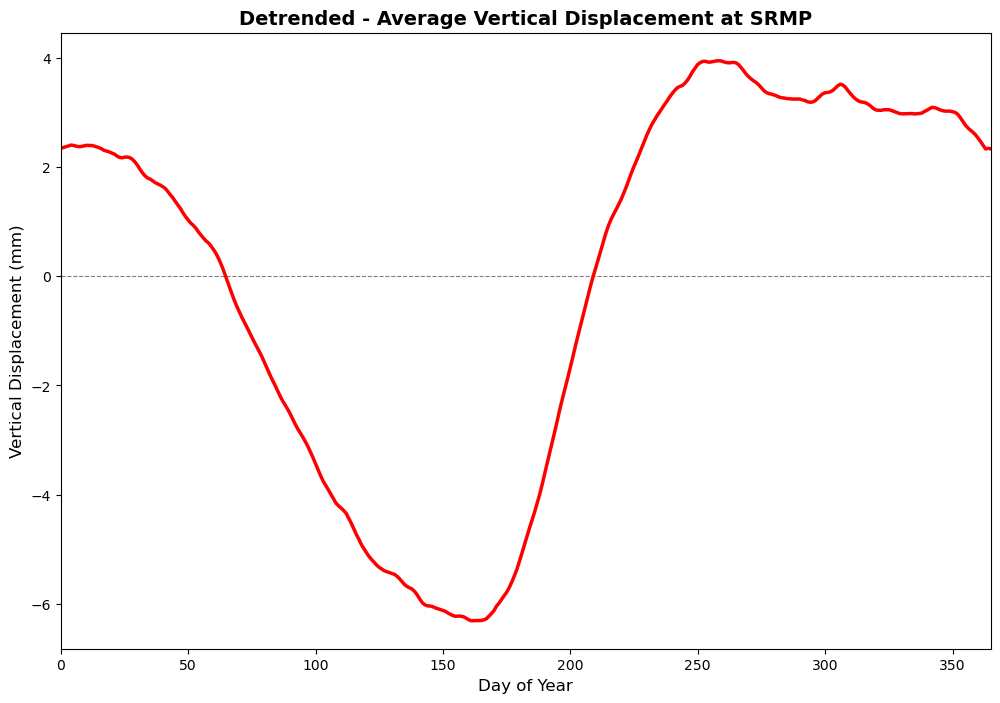

In [208]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import imageio

# --- Setup ---
fig = plt.figure(figsize=(12, 8))
filenames = []

years = sorted(np.unique(rd_data.year))
colormap = cm.get_cmap('viridis', len(years))

plt.xlabel('Day of Year', fontsize=12)
plt.ylabel(f'{Disp} Displacement (mm)', fontsize=12)
plt.title(f'Detrended - Average Vertical Displacement at {station_name}', fontsize=14, weight='bold')
plt.axhline(0, color='gray', linewidth=0.8, linestyle='--')
plt.xlim(0, 365)

days = np.arange(1, 366)
all_years_df = []

# --- Preprocess years and interpolate ---
for year in years:
    data = rd_data[rd_data['year'] == year].copy()
    
    # Remove Feb 29 for non-leap years
    if not ((year % 4 == 0) and ((year % 100 != 0) or (year % 400 == 0))):
        data = data[data['doy'] != 60]
    
    full_range = pd.DataFrame({'doy': days})
    data = full_range.merge(data, on="doy", how="left")
    data['year'] = year
    data[Disp] = data[Disp].interpolate(method="linear", limit=3, limit_direction="both")
    
    # Skip years with too few valid days
    if data[Disp].count() < 350:
        continue
    
    # Remove yearly mean
    data[Disp] = data[Disp] - np.nanmean(data[Disp])
    
    all_years_df.append(data)

all_years_df = pd.concat(all_years_df)

# --- Load LTM and detrend ---
LTM = pd.read_csv('/Users/dlugardo/Documents/GitHub/signal-processing-enu/LTM/files/SRMP_Daily30RollingLTM.csv')
LTM = LTM[Disp]
offset_LTM = LTM - np.nanmean(LTM)

# --- Compute standard deviation ---
STD = all_years_df.groupby('doy')[Disp].std()

upper1 = offset_LTM + STD
lower1 = offset_LTM - STD
upper2 = offset_LTM + 2*STD
lower2 = offset_LTM - 2*STD

# --- Plot LTM and sigma bands ---
plt.plot(days, offset_LTM, color='red', lw=2.5, label='Mean LTM')
plt.fill_between(days, lower1, upper1, color='red', alpha=0.2, label='±1σ')
plt.fill_between(days, lower2, upper2, color='red', alpha=0.1, label='±2σ')

# --- Plot individual years and highlight anomalies ---
for i, year in enumerate(sorted(all_years_df['year'].unique())):
    yr_data = all_years_df[all_years_df['year'] == year]
    yr_disp = yr_data.set_index('doy')[Disp]
    
    mask_anomaly = (yr_disp > upper2) | (yr_disp < lower2)
    
    # Use distinct color for anomalies
    co = 'pink' if mask_anomaly.any() else colormap(i)
    
    plt.plot(days, yr_disp, color=co, lw=1.5, label=str(year))
    
    # Save individual year plot for GIF
    filename = f'/Users/dlugardo/Documents/GitHub/signal-processing-enu/Visualization/PlotsforAnimations/Det{Disp}Disp_{station_name}_{year}.png'
    plt.tight_layout(rect=[0, 0, 0.85, 1])
    plt.savefig(filename, dpi=150)
    filenames.append(filename)

plt.legend(title='Year', loc='center left', bbox_to_anchor=(1, 0.5), fontsize=9)

# --- Save overall mean plot ---
filename_mean = f'/Users/dlugardo/Documents/GitHub/signal-processing-enu/Visualization/PlotsforAnimations/Compressed{Disp}Disp_{station_name}_Mean.png'
plt.savefig(filename_mean, dpi=150)
filenames.append(filename_mean)

# --- Create GIF ---
gif_path = f'/Users/dlugardo/Documents/GitHub/signal-processing-enu/Visualization/Compressed{Disp}Disp_{station_name}.gif'
with imageio.get_writer(gif_path, mode='I', duration=0.2) as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

plt.show()



In [ ]:
# --- plot anomalous years (outside ±1.5σ) ---
for i, year in enumerate(years):
    yr = all_years_df[all_years_df['year'] == year].set_index("doy")

    # align by doy so Series indices match
    yr_disp = yr[Disp]
    yr_upper = upper2.loc[yr.index]
    yr_lower = lower2.loc[yr.index]

    mask_upper = yr_disp > yr_upper
    mask_lower = yr_disp < yr_lower

    if mask_upper.any() or mask_lower.any():
        plt.plot(yr.index, yr_disp, lw=1.5, color=colormap(i), label=str(year))


plt.legend(title="Year", loc='center left', bbox_to_anchor=(1, 0.5), fontsize=9)
plt.tight_layout(rect=[0, 0, 0.85, 1])

# --- save figure ---
filename = f'/Users/dlugardo/Documents/GitHub/signal-processing-enu/Visualization/Compressed{Disp}Disp_{station_name}_Anomalies.png'
plt.savefig(filename, dpi=150)

## Comparision Tables
Amplitudes, Peak, Minima

And then Averaged

In [ ]:
peakval, minimaval, peak, minima, amplitude = [], [], [], [], []

years_used = []

for i, year in enumerate(np.unique(df_rolling.year)):
    data = df_rolling[df_rolling['year'] == str(year)]

    if data.shape[0] > 350:
        years_used.append(year)
        a = data[Disp].idxmin()
        minima.append(data['doy'][a])
        minimaval.append(data[Disp][a])

        b = data[Disp].idxmax()
        peak.append(data['doy'][b])
        peakval.append(data[Disp][b])

        a1 = data[Disp].min()
        b1 = data[Disp].max()
        amplitude.append(b1-a1)

peak = np.array(peak)
peakval = np.array(peakval)
minima = np.array(minima)
minimaval = np.array(minimaval)
amplitude = np.array(amplitude)

arr = np.vstack([peak, peakval, minima, minimaval, amplitude])

# ------- Circular Mean for DOY variables -------

# Compute averages
avg_peak_doy = circular_mean(peak)
avg_min_doy = circular_mean(minima)
avg_peak_val = np.mean(peakval)
avg_min_val = np.mean(minimaval)
avg_amp = np.mean(amplitude)

# Combine yearly data + average as a new column
arr = np.vstack([peak, peakval, minima, minimaval, amplitude])
avg_col = np.array([[avg_peak_doy], [avg_peak_val], [avg_min_doy], [avg_min_val], [avg_amp]])
arr = np.hstack([arr, avg_col])  # now arr.shape = (5, n_years + 1)

# Update year labels
years_used.append("Mean")

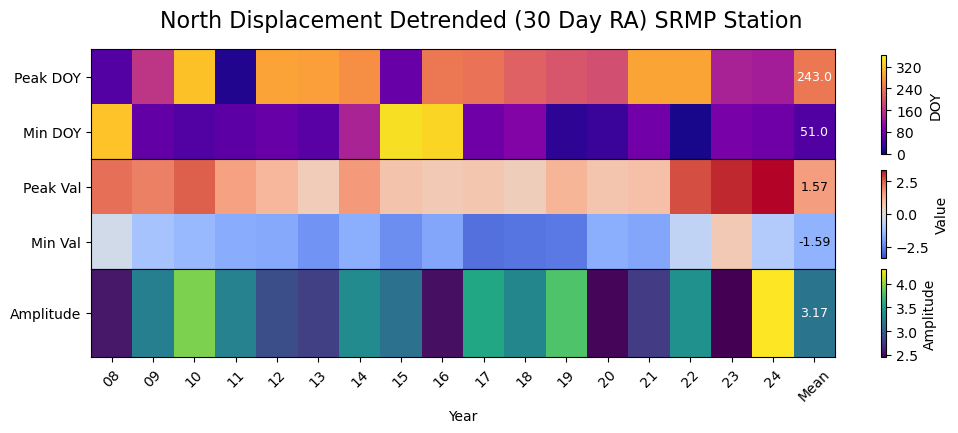

In [ ]:
# Prepare data and labels
row_labels = ['Peak DOY', 'Peak Value', 'Min DOY', 'Min Value', 'Amplitude']
years = np.unique(df_rolling.year)
years = [str(y) for y in years if df_rolling[df_rolling['year'] == str(y)].shape[0] > 350]

# Create figure with GridSpec for tight layout
fig = plt.figure(figsize=(12, 4))
gs = gridspec.GridSpec(3, 1, height_ratios=[1, 1, 0.8], hspace=0.0)

# ---- 1. DOY (Cyclical) ----
ax1 = fig.add_subplot(gs[0])
doy_data = np.vstack([arr[0], arr[2]])  # Peak DOY, Min DOY
im1 = ax1.imshow(doy_data, aspect='auto', cmap='plasma', vmin=0, vmax=365)
ax1.set_yticks([0, 1])
ax1.set_yticklabels(['Peak DOY', 'Min DOY'])
ax1.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
cbar = fig.colorbar(im1, ax=ax1, orientation='vertical', label='DOY', shrink=0.9)
cbar.locator = MaxNLocator(nbins=5)
cbar.update_ticks()

for row_idx in range(doy_data.shape[0]):
    val = doy_data[row_idx, -1]
    ax1.text(doy_data.shape[1]-1, row_idx, f"{val:.1f}", ha='center', va='center', color='white', fontsize=9)

# ---- 2. Peak/Min Values ----
ax2 = fig.add_subplot(gs[1], sharex=ax1)
val_data = np.vstack([arr[1], arr[3]])  # Peak & Min Value

im2 = ax2.imshow(val_data, aspect='auto', cmap='coolwarm', vmin=-np.max(np.abs(val_data)), vmax=np.max(np.abs(val_data)))
ax2.set_yticks([0, 1])
ax2.set_yticklabels(['Peak Val', 'Min Val'])
ax2.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
fig.colorbar(im2, ax=ax2, orientation='vertical', label='Value', shrink=0.8)
for row_idx in range(val_data.shape[0]):
    val = val_data[row_idx, -1]
    ax2.text(val_data.shape[1]-1, row_idx, f"{val:.2f}", ha='center', va='center',
             color='black' if abs(val) < 10 else 'white', fontsize=9)

# ---- 3. Amplitude ----
ax3 = fig.add_subplot(gs[2], sharex=ax1)
amp_data = arr[4:5]  # Amplitude only

im3 = ax3.imshow(amp_data, aspect='auto', cmap='viridis', vmin=np.min(amp_data), vmax=np.max(amp_data))
ax3.set_yticks([0])
ax3.set_yticklabels(['Amplitude'])
ax3.set_xticks(np.arange(len(years_used)))
ax3.set_xticklabels(years_used, rotation=45)

cbar = fig.colorbar(im3, ax=ax3, orientation='vertical', label='Amplitude')
cbar.locator = MaxNLocator(nbins=4)
cbar.update_ticks()

val = amp_data[0, -1]
ax3.text(amp_data.shape[1]-1, 0, f"{val:.2f}", ha='center', va='center', color='white', fontsize=9)

# ---- Global formatting ----

fig.suptitle( "North Displacement Detrended (30 Day RA) SRMP Station", fontsize=16, y=0.98, x= 0.45)
ax3.set_xlabel("Year")

plt.show()

In [ ]:
all_station_averages = []  # Store avg arrays for each station
stations_processed = []

wdays = 30

for station_name in StationMetaData.station:
    try:
        st = StationMetaData[StationMetaData['station'] == str(station_name)]
        lat = st.latitude.values
        lon = st.longitude.values
        
        raw_data = get_data(station_name)
        time = raw_data[:, 0]
        converted_dates = np.array([decimal_year_to_date(dy) for dy in time])

        # Find longest continuous segment of data
        continuous_segment = find_longest_continuous_segment(converted_dates, max_gap_days=MAX_GAP_DAYS)

        if len(continuous_segment) < 365 * 3:
            print(f"  → Skipping {station_name}: continuous segment too short.")
            continue

        # Filter both data and error to this segment
        mask = np.isin(converted_dates, continuous_segment)
        data = raw_data[mask, 1:4]
        error = raw_data[mask, 4:]
        converted_dates = converted_dates[mask]

        # Detrend data
        data_detrended = scipy.signal.detrend(data, axis=0)

        # Build DataFrame
        df = pd.DataFrame({'time': converted_dates})
        df['east'] = data_detrended[:, 0]
        df['north'] = data_detrended[:, 1]
        df['up'] = data_detrended[:, 2]
        df.set_index('time', inplace=True)
        df.index = pd.to_datetime(df.index)

        # Add DoY
        df['doy'] = df.index.dayofyear

        # Rolling mean
        df_rolling = df.rolling(window=wdays, center=True, min_periods=wdays).mean()
        df_rolling['year'] = df_rolling.index.year
        df_rolling = df_rolling.dropna()

        # Initialize metrics
        peakval, minimaval, peak, minima, amplitude = [], [], [], [], []
        years_used = []

        for year in np.unique(df_rolling['year']):
            data_year = df_rolling[df_rolling['year'] == year]

            if data_year.shape[0] > 350:
                years_used.append(year)
                min_idx = data_year[Disp].idxmin()
                max_idx = data_year[Disp].idxmax()

                minima.append(data_year['doy'][min_idx])
                minimaval.append(data_year[Disp][min_idx])

                peak.append(data_year['doy'][max_idx])
                peakval.append(data_year[Disp][max_idx])

                amp = data_year[Disp].max() - data_year[Disp].min()
                amplitude.append(amp)

        # Convert to arrays **once, after loop**
        peak = np.array(peak)
        peakval = np.array(peakval)
        minima = np.array(minima)
        minimaval = np.array(minimaval)
        amplitude = np.array(amplitude)

        # Compute averages
        avg_peak_doy = circular_mean(peak)
        avg_min_doy = circular_mean(minima)
        avg_peak_val = np.mean(peakval)
        avg_min_val = np.mean(minimaval)
        avg_amp = np.mean(amplitude)

        # Stack into a single array for this station
        avg_array = np.array([avg_peak_doy, avg_peak_val, avg_min_doy, avg_min_val, avg_amp, lat[0], lon[0]])
        all_station_averages.append(avg_array)
        stations_processed.append(station_name)


        #print(f"{station_name}: Avg Peak DOY = {avg_peak_doy:.1f}, Amplitude = {avg_amp:.2f}")

    except FileNotFoundError:
        print(f"  → File not found for station {station_name}. Skipping.")
        continue
    except Exception as e:
        print(f"  → Error processing station {station_name}: {e}")
        continue


  → Skipping NGFJ: continuous segment too short.
  → File not found for station THU4. Skipping.
  → File not found for station QENU. Skipping.
  → File not found for station AAS2. Skipping.
  → Skipping EQNU: continuous segment too short.
  → Skipping SCOB: continuous segment too short.
  → File not found for station SCO4. Skipping.
  → File not found for station STNO. Skipping.
  → File not found for station QAQ2. Skipping.
  → File not found for station KLQ3. Skipping.
  → Skipping UPAK: continuous segment too short.
  → Skipping AVAN: continuous segment too short.
  → Skipping THU1: continuous segment too short.
  → File not found for station THU3. Skipping.
  → Error processing station KSNB: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (17,) + inhomogeneous part.
  → Skipping NUNA: continuous segment too short.
  → Error processing station MIK2: setting an array element with a sequence. The reque

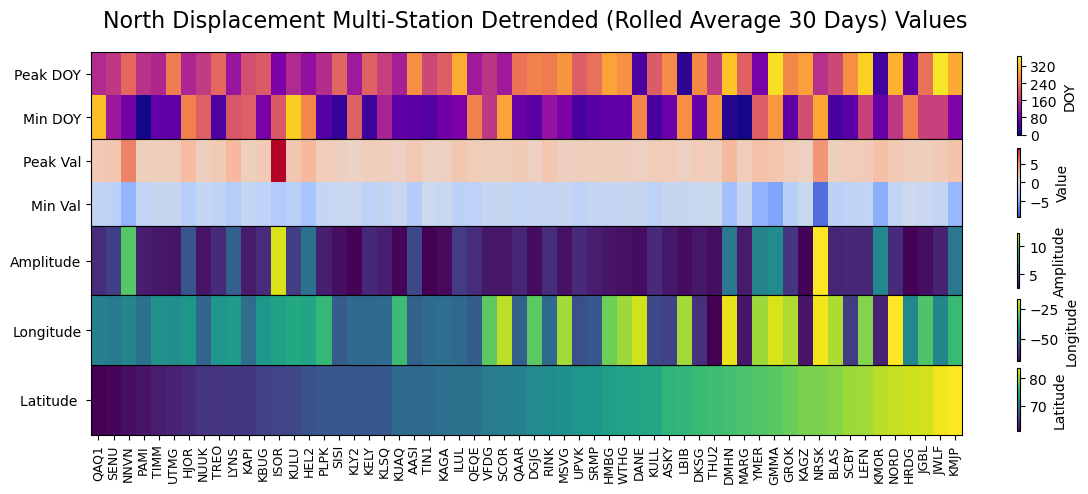

In [ ]:
arr = np.array(all_station_averages).T
row_labels = ['Peak DOY', 'Peak Value', 'Min DOY', 'Min Value', 'Amplitude', 'Latitude', 'Longitude']
stations = stations_processed

fig = plt.figure(figsize=(12, 5))
gs = gridspec.GridSpec(5, 1, height_ratios=[1, 1, 0.8, 0.8, 0.8], hspace=0.0)

latitudes = arr[5]
sorted_indices = np.argsort(latitudes)

# Step 2: Sort the array and stations
arr = arr[:, sorted_indices]
stations = [stations[i] for i in sorted_indices]

# ---- 1. DOY (Cyclical) ----
ax1 = fig.add_subplot(gs[0])
doy_data = arr[0:3:2]  # Peak DOY, Min DOY
im1 = ax1.imshow(doy_data, aspect='auto', cmap='plasma', vmin=0, vmax=365)
ax1.set_yticks([0, 1])
ax1.set_yticklabels(['Peak DOY', 'Min DOY'])
ax1.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
cbar = fig.colorbar(im1, ax=ax1, orientation='vertical', label='DOY', shrink=0.9)
cbar.locator = MaxNLocator(nbins=5)
cbar.update_ticks()

# ---- 2. Peak/Min Values ----
ax2 = fig.add_subplot(gs[1], sharex=ax1)
val_data = arr[1:4:2]  # Peak Val, Min Val
im2 = ax2.imshow(val_data, aspect='auto', cmap='coolwarm', vmin=-np.max(np.abs(val_data)), vmax=np.max(np.abs(val_data)))
ax2.set_yticks([0, 1])
ax2.set_yticklabels(['Peak Val', 'Min Val'])
ax2.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
fig.colorbar(im2, ax=ax2, orientation='vertical', label='Value', shrink=0.8)


# ---- 3. Amplitude ----
ax3 = fig.add_subplot(gs[2], sharex=ax1)
amp_data = arr[4:5]  # Amplitude only
im3 = ax3.imshow(amp_data, aspect='auto', cmap='viridis', vmin=np.min(amp_data), vmax=np.max(amp_data))
ax3.set_yticks([0])
ax3.set_yticklabels(['Amplitude'])
ax3.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
fig.colorbar(im3, ax=ax3, orientation='vertical', label='Amplitude', shrink=0.8)

# ---- 3. Lat ----
ax4 = fig.add_subplot(gs[4], sharex=ax1)
lat_data = arr[5:6]  # Ampitude only
im4 = ax4.imshow(lat_data, aspect='auto', cmap='viridis')
ax4.set_yticks([0])
ax4.set_yticklabels(['Latitude '])

ax4.set_xticks(np.arange(len(stations)))
ax4.set_xticklabels(stations, rotation=90, fontsize=9)

fig.colorbar(im4, ax=ax4, orientation='vertical', label='Latitude', shrink = 0.9)

# ---- 3. Longitude ----
ax5 = fig.add_subplot(gs[3], sharex=ax1)
lon_data = arr[6:7]  # Amplitude only
im5 = ax5.imshow(lon_data, aspect='auto', cmap='viridis')
ax5.set_yticks([0])
ax5.set_yticklabels(['Longitude'])
ax5.tick_params(axis='x', which='both', bottom=False, labelbottom=False)

fig.colorbar(im5, ax=ax5, orientation='vertical', label='Longitude', shrink = 0.9)

# ---- Global formatting ----
fig.suptitle("North Displacement Multi-Station Detrended (Rolled Average 30 Days) Values", fontsize=16, y=0.98, x=0.45)
ax3.set_xlabel("Station")

plt.tight_layout()
plt.show()


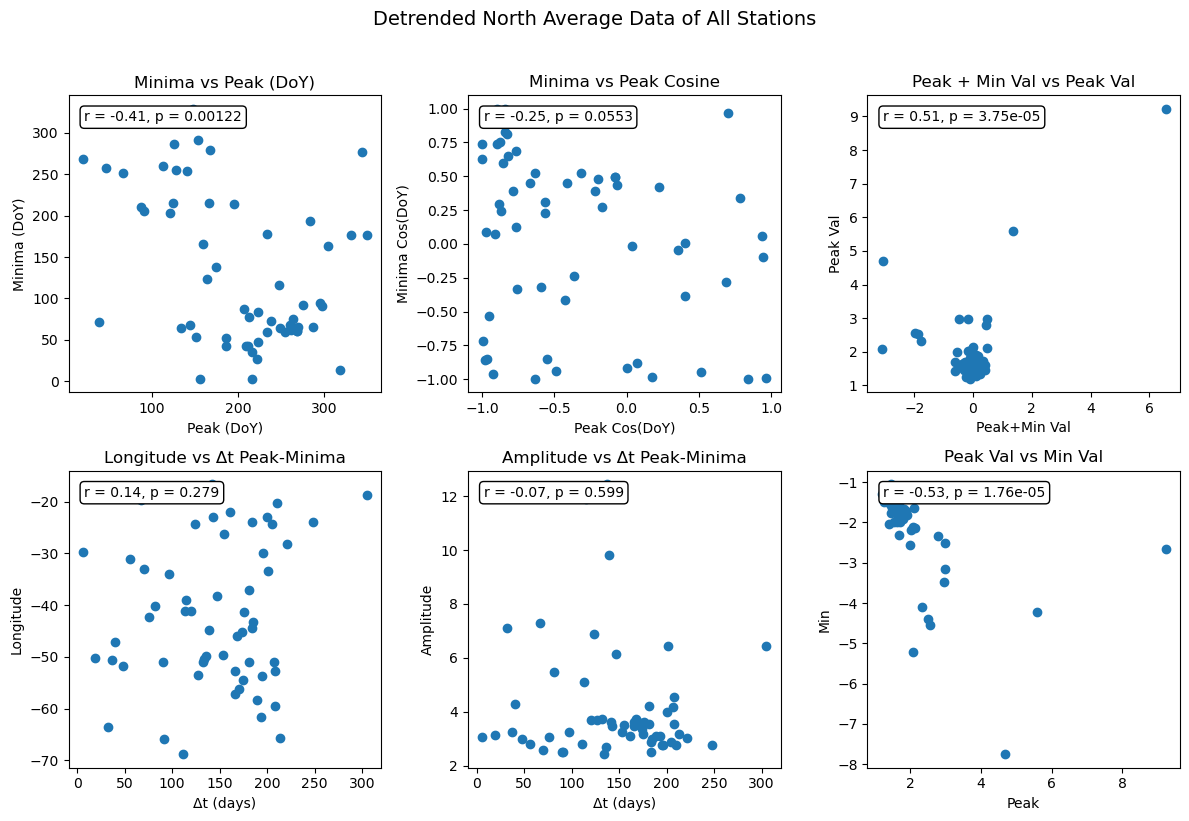

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Example function (replace with your actual implementation)
def doy_to_angle(doy):
    return np.cos(2 * np.pi * doy / 365.0)

# Create the subplots
fig, axs = plt.subplots(2, 3, figsize=(12, 8))

# Subplot 1: Minima vs Peak (DoY)
x = doy_data[0, :]
y = doy_data[1, :]
r, p = pearsonr(x, y)
axs[0, 0].scatter(x, y)
axs[0, 0].set_title('Minima vs Peak (DoY)')
axs[0, 0].set_xlabel('Peak (DoY)')
axs[0, 0].set_ylabel('Minima (DoY)')
axs[0, 0].annotate(f'r = {r:.2f}, p = {p:.3g}', xy=(0.05, 0.95), xycoords='axes fraction',
                   ha='left', va='top', fontsize=10, bbox=dict(boxstyle="round", fc="w"))

# Subplot 2: Minima vs Peak Cosine
x = [doy_to_angle(d) for d in doy_data[0, :]]
y = [doy_to_angle(d) for d in doy_data[1, :]]
r, p = pearsonr(x, y)
axs[0, 1].scatter(x, y)
axs[0, 1].set_title('Minima vs Peak Cosine')
axs[0, 1].set_xlabel('Peak Cos(DoY)')
axs[0, 1].set_ylabel('Minima Cos(DoY)')
axs[0, 1].annotate(f'r = {r:.2f}, p = {p:.3g}', xy=(0.05, 0.95), xycoords='axes fraction',
                   ha='left', va='top', fontsize=10, bbox=dict(boxstyle="round", fc="w"))

# Subplot 3: Latitude vs Δt Peak-Minima
x = np.abs(doy_data[0, :] - doy_data[1, :])
y = lon_data[0]
r, p = pearsonr(x, y)
axs[1, 0].scatter(x, y)
axs[1, 0].set_title('Longitude vs Δt Peak-Minima')
axs[1, 0].set_xlabel('Δt (days)')
axs[1, 0].set_ylabel('Longitude')
axs[1, 0].annotate(f'r = {r:.2f}, p = {p:.3g}', xy=(0.05, 0.95), xycoords='axes fraction',
                   ha='left', va='top', fontsize=10, bbox=dict(boxstyle="round", fc="w"))

# Subplot 4: Amplitude vs Δt Peak-Minima
x = np.abs(doy_data[0, :] - doy_data[1, :])
y = amp_data[0]
r, p = pearsonr(x, y)
axs[1, 1].scatter(x, y)
axs[1, 1].set_title('Amplitude vs Δt Peak-Minima')
axs[1, 1].set_xlabel('Δt (days)')
axs[1, 1].set_ylabel('Amplitude')
axs[1, 1].annotate(f'r = {r:.2f}, p = {p:.3g}', xy=(0.05, 0.95), xycoords='axes fraction',
                   ha='left', va='top', fontsize=10, bbox=dict(boxstyle="round", fc="w"))

#S5
x = val_data[0] + val_data[1]
y = val_data[0]
r, p = pearsonr(x, y)
axs[0, 2].scatter(x, y)
axs[0, 2].set_title('Peak + Min Val vs Peak Val')
axs[0, 2].set_xlabel('Peak+Min Val')
axs[0, 2].set_ylabel('Peak Val')
axs[0, 2].annotate(f'r = {r:.2f}, p = {p:.3g}', xy=(0.05, 0.95), xycoords='axes fraction',
                   ha='left', va='top', fontsize=10, bbox=dict(boxstyle="round", fc="w"))
#S6 
x = val_data[0]
y = val_data[1]
r, p = pearsonr(x, y)
axs[1, 2].scatter(x, y)
axs[1, 2].set_title('Peak Val vs Min Val')
axs[1, 2].set_xlabel('Peak')
axs[1, 2].set_ylabel('Min')
axs[1, 2].annotate(f'r = {r:.2f}, p = {p:.3g}', xy=(0.05, 0.95), xycoords='axes fraction',
                   ha='left', va='top', fontsize=10, bbox=dict(boxstyle="round", fc="w"))
# Add main title and adjust layout
fig.suptitle('Detrended North Average Data of All Stations', fontsize=14, y=1.02)
fig.tight_layout()
plt.show()


## Grace Data

In [ ]:
Grace = pd.read_csv('/Users/dlugardo/Documents/GitHub/signal-processing-enu/SRMPGrace.csv')
Grace

In [ ]:
Grace = Grace.set_index('DateTime')
Grace

In [ ]:
GraceSamePeriod = Grace.loc['2007-09':'2025-02']
GraceSamePeriod

data_detrended = scipy.signal.detrend(GraceSamePeriod, axis=0)

# Build DataFrame
df = pd.DataFrame({'time': GraceSamePeriod.index})
df['grace'] = data_detrended
df.set_index('time', inplace=True)
df.index = pd.to_datetime(df.index)
df['month'] = df.index.strftime('%m')

ltmgrace = df.groupby('month')['grace'].mean()
ltmgrace

In [ ]:
plt.bar(ltmgrace.index,ltmgrace)
plt.title("Detrended Grace Water Equivalent Thickness")
plt.xlabel('Month')
plt.ylabel('Water Equivalent Thickness (m)')